In [25]:
import lightgbm as lgb
import pandas as pd
import numpy as np

In [26]:
from sklearn.model_selection import train_test_split

In [97]:
"From kaggle competition evaluation metrix"
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d),g,d

In [121]:
final_data=pd.read_csv('Final_Data.csv')
req=final_data.columns
req=req[1:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2,shuffle=True)

In [105]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,roc_curve,auc,roc_auc_score

In [122]:
light=lgb.LGBMClassifier(learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=94,
                          colsample_bytree=0.19,
                          max_bins=517, random_state=1)

In [123]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [4,5,6,8],
    'n_estimators': [500,800,1000,1200]
}
best_param=GridSearchCV(estimator=light,
                       param_grid=params)
best_param.fit(train_x,train_y)

GridSearchCV(estimator=LGBMClassifier(colsample_bytree=0.19, learning_rate=0.03,
                                      max_bins=517, min_child_samples=2400,
                                      num_leaves=94, random_state=1,
                                      reg_lambda=50),
             param_grid={'max_depth': [4, 5, 6, 8],
                         'n_estimators': [500, 800, 1000, 1200]})

In [127]:
best_param=best_param.best_estimator_

In [120]:
print(best_param)

LGBMClassifier(colsample_bytree=0.19, learning_rate=0.03, max_bins=517,
               max_depth=5, min_child_samples=2400, n_estimators=1000,
               num_leaves=94, random_state=1, reg_lambda=50)


In [128]:
best_param.fit(train_x,train_y)

LGBMClassifier(colsample_bytree=0.19, learning_rate=0.03, max_bins=517,
               max_depth=6, min_child_samples=2400, n_estimators=1200,
               num_leaves=94, random_state=1, reg_lambda=50)

In [110]:
import matplotlib.pyplot as plt

The Accuracy Score is 0.8712022460643738
The Precision is 0.731682769726248
The recall is 0.746253336070622
The f1 score is 0.7388962292915947
The area under curve 0.9314196008256805


Text(0.5, 1.0, 'ROC Curve')

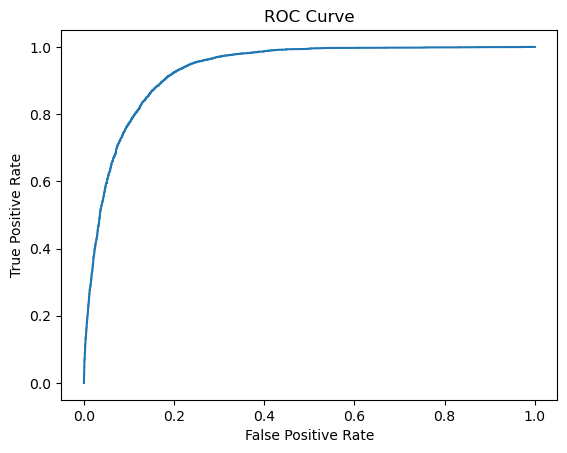

In [129]:
print("The Accuracy Score is {}".format(accuracy_score(best_param.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,best_param.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=best_param.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

C:\Users\Devansh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


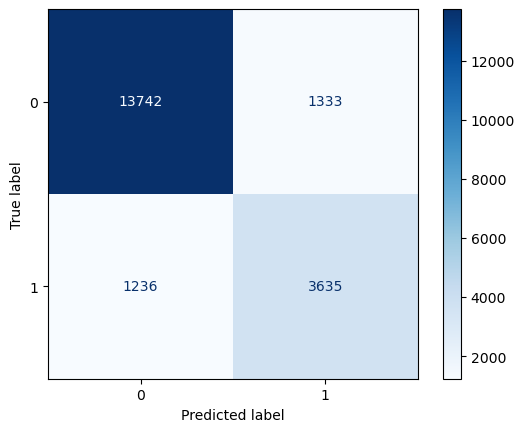

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(test_y,best_param.predict(test_x))
m=plot_confusion_matrix(best_param,test_x,test_y, cmap=plt.cm.Blues)
plt.show()

In [131]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y[:,1],columns=['prediction'])

In [132]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.8628306949167194
Top 4% capture 0.4744405666187641
Final eval metric 0.6686356307677417


In [44]:
final_data=pd.read_csv('Final_Data_new.csv')
req=final_data.columns
req=req[2:-1]
target=final_data['target']
data_x=final_data[req]
train_x,test_x,train_y,test_y=train_test_split(data_x,target,test_size=0.2)

In [45]:
params = {
    'max_depth': [4,5,6,8],
    'n_estimators': [500,800,1000,1200]
}
best_param=GridSearchCV(estimator=light,
                       param_grid=params)
best_param.fit(train_x,train_y)

GridSearchCV(estimator=LGBMClassifier(colsample_bytree=0.19, learning_rate=0.03,
                                      max_bins=517, min_child_samples=2400,
                                      num_leaves=94, random_state=1,
                                      reg_lambda=50),
             param_grid={'max_depth': [4, 5, 6],
                         'n_estimators': [500, 800, 1000]})

In [46]:
best_param=best_param.best_estimator_
best_param.fit(train_x,train_y)

LGBMClassifier(colsample_bytree=0.19, learning_rate=0.03, max_bins=517,
               max_depth=6, min_child_samples=2400, n_estimators=1000,
               num_leaves=94, random_state=1, reg_lambda=50)

The Accuracy Score is 0.8664393863431264
The Precision is 0.7376947040498443
The recall is 0.7171411265899454
The f1 score is 0.7272727272727272
The area under curve 0.9284859483991783


Text(0.5, 1.0, 'ROC Curve')

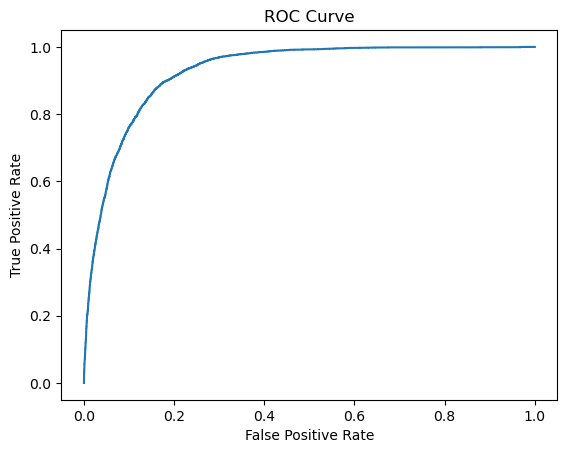

In [47]:
print("The Accuracy Score is {}".format(accuracy_score(best_param.predict(test_x),test_y)))
pre_recall_f1=precision_recall_fscore_support(test_y,best_param.predict(test_x),average='binary')
print("The Precision is {}".format(pre_recall_f1[0]))
print("The recall is {}".format(pre_recall_f1[1]))
print("The f1 score is {}".format(pre_recall_f1[2]))
pred_proba_y=best_param.predict_proba(test_x)
fpr, tpr, thresholds_roc = roc_curve(test_y,pred_proba_y[:,1])
roc_auc = auc(fpr,tpr)
print("The area under curve {}".format(roc_auc))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [101]:
test_y_num=np.array(test_y)
df=pd.DataFrame(test_y_num,columns=['target'])
df2=pd.DataFrame(pred_proba_y[:,1],columns=['prediction'])

In [103]:
gd,g,d=amex_metric(df,df2)
print("Gini coefficient {}".format(g))
print("Top 4% capture {}".format(d))
print("Final eval metric {}".format(gd))

Gini coefficient 0.856962980829062
Top 4% capture 0.47203714920250356
Final eval metric 0.6645000650157827
